# CSPB 3202 - Final Project 

#### GitHub URL: 
https://github.com/dudeilovemae/3202_final_project.git

## Reinforcement Learning - Lunar Lander

### Table of Contents

1. Overview
2. Approach
3. Results
4. Conclusion
5. References

### Overview

In this project, I'm going to be creating an agent to control the Lunar Lander Box2D environment from Gymnasium. The Lunar Lander environment can be referenced here: 

https://gymnasium.farama.org/environments/box2d/lunar_lander/

To begin I will implement a random agent to control the Lunar Lander. Then I will implement a heuristic agent. Finally I will implement a reinforcement learning model. 

#### Lunar Lander Environment Description

**Objective**

The objective of the Lunar Landar Environment is to land between the flags. 

**Action Space**

There are 4 actions that can be taken:

* 0: Do Nothing
* 1: Fire Left Engine
* 2: Fire Main Engine
* 3: Fire Right Engine

**Observables**

Example observable:

```Box([ -2.5 -2.5 -10. -10. -6.2831855 -10. -0. -0. ], [ 2.5 2.5 10. 10. 6.2831855 10. 1. 1. ], (8,), float32)```

Decoded values:
|Definition|Value|
|:---------|:----|
|x coordinate|-2.5|
|y coordinate|-2.5|
|x linear velocity|-10|
|y linear velocity|-10|
|angle|-6.2831855|
|angular velocity|-10|
|leg one touchdown|0|
|leg two touchdown|0|

**Reward Criteria**

Each step the following items impact the reward.

- Distance from landing pad
- Movement speed
- Lander tilt
- Contact of each leg
- Number of times the engines are fired
- Landing safely

The total reward is the sum of all the rewards for all steps in the episode. OpenAI states that an episode is considered a solution of it scores at least 200 points. 

**Termination Criteria**

The episode is terminated if the lander crashes, it gets outside the viewpoint, or it's not active.


### Approach

My project is organized as the following:

|File/Folder|Purpose|
|:---------|:----|
|franco_final_project.ipynb|A jupyter notebook containing my final project deliverables|
|scripts|A folder containing python scripts I have created|
|utils|A folder containing useful utilities I've created to assist with this assignment|
|ai_env.yml|An export of my conda environment. It can be imported on different machines. See README|
|featured_models|This directory contains models that I've created and want to showcase|
|assignment_definition|A folder containing project details given to us by the professor|
|gym_demos|A folder containing demos from the openAI gym website|

I try to maintain all the python scripts in the code blocks in the scripts directory. I thought it would make it easier for version control of individual scripts. They can be viewed and run separately there. This notebook should be a walkthrough of my project, but the majority of the development was done in python under the scripts directory. 

To begin I'm going to start with the random agent. This will allow me to get my environment set up and have a good starting point for this project.
Next I will implement a heuristic agent to follow simple rules. I want to compare the two agents and see how they perform. 

Finally I want to implement a DQN agent by training a model. For the DQN agent I will be using stable_baselines3. I will also be using tensorboard to evaluate the models I create. 

### Results


#### Random Agent




Running 10 episodes...
Saving vides to: videos/lunarLander_random

Episode 1: 73 steps, reward = -52.44068674916055, success: False 
Episode 2: 100 steps, reward = -68.72294206331465, success: False 
Episode 3: 111 steps, reward = -271.12208544485566, success: False 
Episode 4: 75 steps, reward = -86.9424840150586, success: False 
Episode 5: 108 steps, reward = -184.42270771779147, success: False 
Episode 6: 102 steps, reward = -273.15156891953825, success: False 
Episode 7: 99 steps, reward = -198.14063803221595, success: False 
Episode 8: 105 steps, reward = -134.9284588193038, success: False 
Episode 9: 87 steps, reward = -206.35854208580827, success: False 
Episode 10: 108 steps, reward = -121.56085040250723, success: False 


MoviePy - Building file  videos/lunarLander_random/rand-episode-0.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: videos/lunarLander_random/rand-episode-0.gif.

Displaying gif from episode 1:


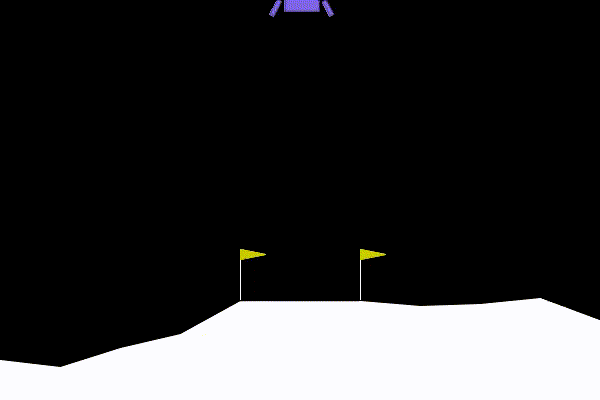

In [1]:
# version controlled in scripts/lunarLander_random_record.ppy

import gymnasium as gym
from gymnasium.wrappers import  RecordVideo
from IPython.display import Image
from moviepy.editor import VideoFileClip

# Initialize the Lunar Lander Environment 
env = gym.make("LunarLander-v3", render_mode="rgb_array")
num_of_episodes = 10
folder="videos/lunarLander_random"


# install env wrapper to record a video
env = RecordVideo(
    env,
    video_folder=folder,                  # Folder
    name_prefix="rand",                   # Video filename prefix
    episode_trigger=lambda x: True        # Record every episode
)

print(f"Running {num_of_episodes} episodes...")
print(f"Saving vides to: {folder}\n")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False

    while not episode_over:
        # For now we will use a random agent
        action = env.action_space.sample()

        # Take the random action and receive information 
        observation, reward, terminated, truncated, info = env.step(action)
        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = total_score >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

# convert the first mp4 to a gif and show it
first_video = VideoFileClip("videos/lunarLander_random/rand-episode-0.mp4")
#first_video = first_video.resize(0.5)
first_video.write_gif("videos/lunarLander_random/rand-episode-0.gif", program="ffmpeg")

print("\nDisplaying gif from episode 1:")
Image(filename="videos/lunarLander_random/rand-episode-0.gif")

In this script I executed 10 episodes with an agent that performs random actions. For each set I output some simple metrics. We can see the number of steps taken, total reward for the episode, and if it's a valid solution. The gymnasium documentation defines a valid solution as a score of 200 or greater. For each episode I saved a mp4 video in the video/lunarLander_random directory. Finally I displayed the first episode as a gif embedded in this jupyter notebook. 

Visual inspection of the gif from the first episode shows the lander immediately crashing. It's score was under the 200 threshold and was a failure. In fact all 10 episodes are considered a failure. Which is expected a random agent can't properly land. 

#### Heuristic Agent

Let's see if we can implement a heuristic agent that can do better. 

We've already defined all of the observable values in the section above. Let's pull them out of the env so we can closer evaluate them. 




In [2]:
# version controlled in scripts/lunarLander_heuristic_explore.py

import gymnasium as gym
from gymnasium.wrappers import  RecordVideo
from IPython.display import Image
from moviepy.editor import VideoFileClip

from collections import namedtuple

# Create a named tuple to hold observation data
Observation = namedtuple("Observation", ["x", "y", "x_vel", "y_vel", "angle", "angular_vel", "touch1", "touch2"])

# Initialize the Lunar Lander Environment this time with a limit on episode steps
env = gym.make("LunarLander-v3", max_episode_steps=20)
num_of_episodes = 1


print(f"Running {num_of_episodes} episodes...")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False


    while not episode_over:
        # For now we will use a random agent
        action = env.action_space.sample()

        # Take the random action and receive information 
        observation, reward, terminated, truncated, info = env.step(action)

        # Put observation into the named tuple I created
        obs_tuple = Observation(*observation)
        
        # Print observation for examination
        print(f"observation: {obs_tuple}")

        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = reward >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

Running 1 episodes...
observation: Observation(x=np.float32(0.0104228975), y=np.float32(1.3877133), x_vel=np.float32(0.520387), y_vel=np.float32(-0.52868134), angle=np.float32(-0.009781112), angular_vel=np.float32(-0.07394984), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(0.015589619), y=np.float32(1.3752177), x_vel=np.float32(0.5203984), y_vel=np.float32(-0.55538785), angle=np.float32(-0.013475918), angular_vel=np.float32(-0.073902756), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(0.0206316), y=np.float32(1.3626932), x_vel=np.float32(0.50856364), y_vel=np.float32(-0.556689), angle=np.float32(-0.01779237), angular_vel=np.float32(-0.086337045), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(0.025749493), y=np.float32(1.3495743), x_vel=np.float32(0.51807654), y_vel=np.float32(-0.58314866), angle=np.float32(-0.024010789), angular_vel=np.float32(-0.12437995), touch1=np.f

Here I ran through 20 states to get an idea of the different observables. I put the observation data into a named tuple. I'm hoping that this will make it easier to decode and use. 

The objective here is to land between the flags. So with this heuristic agent I can adjust left and right if I'm in the wrong area. I can know the position with the x and y values. I think if the body of the lander hits the ground it's a negative reward. So I need to keep track of if I'm landing flat. I can look at the angle values to determine that. Finally the lander will also crash if it's descending too rapidly. I can determine it's fall speed with x_vel. 

So overall, given a state I want to do the following:

- Not between the flags: Adjust course
- Not landing flat: straighten the lander
- descending too rapidly: slow down



Running 10 episodes...
Saving vides to: videos/lunarLander_heuristic

Episode 1: 214 steps, reward = 14.150612734829792, success: False 
Episode 2: 210 steps, reward = -39.322168734567356, success: False 
Episode 3: 373 steps, reward = 274.2814451330074, success: True 
Episode 4: 246 steps, reward = -1.5450835218421162, success: False 
Episode 5: 204 steps, reward = 28.18481829399755, success: False 
Episode 6: 240 steps, reward = -26.61833630901954, success: False 
Episode 7: 215 steps, reward = 11.461991560166652, success: False 
Episode 8: 205 steps, reward = -23.306280411246178, success: False 
Episode 9: 213 steps, reward = -9.423523957206044, success: False 
Episode 10: 247 steps, reward = -4.924207294891644, success: False 


MoviePy - Building file  videos/lunarLander_heuristic/heuristic-episode-0.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: videos/lunarLander_heuristic/heuristic-episode-0.gif.

Displaying gif from episode 1:


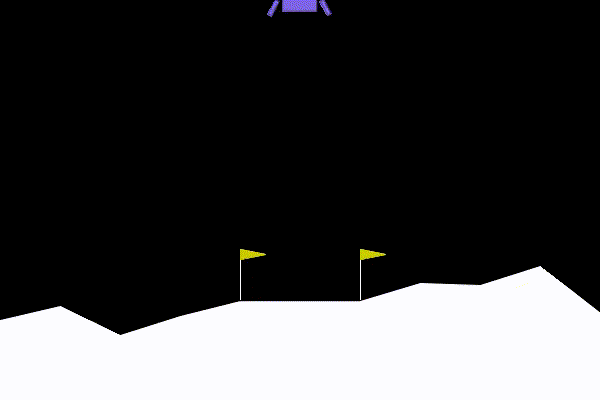

In [3]:
# version controlled in scripts/lunarLander_heuristic.py

import gymnasium as gym
from gymnasium.wrappers import  RecordVideo
from IPython.display import Image
from moviepy.editor import VideoFileClip

from collections import namedtuple
from enum import Enum
import random

# Create a named tuple to hold observation data
Observation = namedtuple("Observation", ["x", "y", "x_vel", "y_vel", "angle", "angular_vel", "touch1", "touch2"])

# Create enum for action space
class LunarAction(Enum):
    IDLE = 0
    FIRE_RIGHT = 1
    FIRE_MAIN = 2
    FIRE_LEFT = 3


def lunar_heuristic(obs):
    obs_tuple = Observation(*obs)

    # Priority 0: If touch down do nothing
    if obs_tuple.touch1 and obs_tuple.touch2:
        return LunarAction.IDLE.value

    # Priority 1: Control Fall Speed
    if obs_tuple.y_vel < -.3:
        return LunarAction.FIRE_MAIN.value
    
    # Priority 2: Too much tilt
    if obs_tuple.angle > .15:
        return LunarAction.FIRE_LEFT.value
    if obs_tuple.angle < -.15:
        return LunarAction.FIRE_RIGHT.value

    # Priority 3: Not between flags
    if obs_tuple.x < -.15:
        return LunarAction.FIRE_LEFT.value
    if obs_tuple.x > .15:
        return LunarAction.FIRE_RIGHT.value
    
    return LunarAction.IDLE.value
    

# Initialize the Lunar Lander Environment 
env = gym.make("LunarLander-v3", render_mode="rgb_array")
num_of_episodes = 10
folder="videos/lunarLander_heuristic"


# install env wrapper to record a video
env = RecordVideo(
    env,
    video_folder=folder,                  # Folder
    name_prefix="heuristic",              # Video filename prefix
    episode_trigger=lambda x: True        # Record every episode
)

print(f"Running {num_of_episodes} episodes...")
print(f"Saving vides to: {folder}\n")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False

    while not episode_over:
        # Simple Heuristic agent
        action = lunar_heuristic(observation)

        # Take the random action and receive information 
        observation, reward, terminated, truncated, info = env.step(action)
        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = total_score >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

# convert the first mp4 to a gif and show it
first_video = VideoFileClip("videos/lunarLander_heuristic/heuristic-episode-0.mp4")
#first_video = first_video.resize(0.5)
first_video.write_gif("videos/lunarLander_heuristic/heuristic-episode-0.gif", program="ffmpeg")

print("\nDisplaying gif from episode 1:")
Image(filename="videos/lunarLander_heuristic/heuristic-episode-0.gif")

With the heuristic agent we can see that it's a little smarter. In general the total reward is higher and even occasionally (if we are lucky) over the success criteria. Maybe we are just getting a bad sample. Let's run a lot more episodes with the random and heuristic agent and compare. 

In [4]:
# Running my statistic scripts from the scripts directory
# They are slight modifications of the previous scripts.
# I'm not putting them in the notebook so it's not cluttered, but
# if you want to view them they are available.

%run scripts/lunarLander_random_stats.py

# adding space between outputs
print("\n")

%run scripts/lunarLander_heuristic_stats.py

Running 500 random agent episodes...

Stats for 500 random agent episodes:
Average score: -183.31549821441675
Success count: 0
Success rate: 0.0


Running 500 heuristic agent episodes...


Stats for 500 random agent episodes:
Average score: -3.1192539555632193
Success count: 35
Success rate: 0.07


The results show that with 500 episodes the heuristic agent is doing much better than the random agent. It's score on average is much higher and it occasionally has success. 

#### DQN Agent

Next I've attempted to implement a DQN Agent. I'm using stable-baseline3 to jump-start this process.

My process is: 

- Run scripts/lunarLander_DQN_train.py
  - To get an initial model started. It runs for 50000 timesteps.
- Run scripts/lunarLander_DQN_train_load.py
  - This model loads the first one and trains for another 50000 timesteps.
  - This script can be run repeatedly until training is sufficient.
- At any point the following can be run to diagnose
  - scripts/lunarLander_DQN_model_read.py
    - This file will load a model and read the meta data
    - The most helpful part is it will show the number of timesteps performed
  - scripts/lunarLander_DQN_view.py
    - Sometimes it's useful to see the agent in action so this script will play an episode
  - scripts/lunarLander_DQN_record.py
    - This script will save a recording of the model
   
Additionally the model is saving data into the log directory than can be used by TensorBoard. To view this run the following:

```tensorboard --logdir ./logs/dqn_tensorboard_log```

It will give you a URL. The results of the logs can be viewed there. 

#### DQN Agent in action



In [5]:
# version controlled in scripts/lunarLander_DQN_train.py

# Had to revert to gym for sb3
import gym 
from stable_baselines3 import DQN
import stable_baselines3.common.evaluation as eval

# Init the lunar lander env
# had to revert to v2 for sb3
env = gym.make("LunarLander-v2")


model = DQN("MlpPolicy", 
            env, 
            verbose=0, # Supressing output 
            tensorboard_log="logs/dqn_tensorboard_log")

print(f"Calling learn for 50000 timesteps...")
model.learn(total_timesteps=50_000, log_interval=4)
model.save("models/dqn_lunarlander_v1")
print(f"Learn complete. ")

print(f"Now evaluating policy")
avg_reward, std_reward = eval.evaluate_policy(model, env, n_eval_episodes=25, deterministic=True)

print(f"\nEvaluation has shown: \nAverage Reward: {avg_reward}\nStandard Dev: {std_reward}")

obs = env.reset()
env.close()


Calling learn for 50000 timesteps...
Learn complete. 
Now evaluating policy

Evaluation has shown: 
Average Reward: -117.46363435387495
Standard Dev: 41.35314138217156


In [6]:
%run scripts/record_DQN_model.py models/dqn_lunarlander_v1.zip "initial"

Running 1 episodes...
Saving video to: videos/lunarLander_DQN



In [8]:
from IPython.display import Video
Video("videos/lunarLander_DQN/initial-episode-0.mp4")

Here I have run the initial training script for 50000 timesteps. As we can see from the evaluation output the performance is very poor. 

Next I'm going to learn and train this model in 50000 timestep increments. It take a couple of rounds for it to get interesting. 

In [9]:
# At this step I ran lunarLander_DQN_train_load.py multiple times. 
# I'm not including it here since it takes a while to run. 
# See: scripts/lunarLander_DQN_train_load.py to see the code 
# and manually run if desired. 


As part of this process I created a model which I'm saving as dqn_lunarlander_model_default.zip in the featured_models directory. 
Using my read_DQN_model_metadata.py script I will inspect it here:

In [10]:
%run scripts/read_DQN_model_metadata.py featured_models/dqn_lunarlander_model_default.zip


Viewing the metadata for model: featured_models/dqn_lunarlander_model_default.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

---- Meta Data for model: featured_models/dqn_lunarlander_model_default.zip ----
Algorithm: DQN
Policy: DQNPolicy
Obs Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Action Space: Discrete(4)
Device: cpu
-- Hyperparameters:
Learning Rate: 0.0001
Gamma: 0.99
Batch size: 32
Buffer size: 1000000
-- Training Done:
Timesteps: 300000
Episodes: 797


As we can see as part of the meta data output I've trained the model 300k timesteps. Using the listed hyper parameters. 

Here is the model in action: 

In [12]:
Video("featured_models/videos/lunarLander_DQN/default-episode-0.mp4")

Here we can see the results of the 300k timestep training. The lander is able to maintain a hover and no longer crash. However it does not commit to the ultimate goal of actually landing. Without landing it's not reaching the reward criteria of 200 to be considered a success. 

Let's turn to the TensorBoard graphs for more insight. 

![reward_mean](screenshots/DQN_v1_ep_rew_mean.png)

We see a lot of variation in the rewards in the first 50k timesteps. Between 50k and 150k there's a steady increase, but after 150k timesteps we aren't improving in the score as much. 

![length_mean](screenshots/DQN_v1_ep_len_mean.png)

Next this chart is episode length mean. Here we can see that after 50K we have a steady increase in episode length. At 150k timesteps the agent hits the max allowed timesteps of 1000. 

I believe these charts are showing that the lander learns to hover while slowly increasing it's score. It does not realize yet that theres a bonus for landing. It continues to get points as it hovers. I don't believe that just increasing the training timesteps will give us the desired results. Currently I'm running with the default hyperparameters. It's time to tweak some of these and start over. 

#### Optimized DQN

As part of the tweaks I want to agent to explore for longer in hopes that it will find that landing is a positive reward. I can do this my modifying the epsilon and exploration_fraction. I also want to adjust the discount factor gamma to have it prioritize longer term rewards such as landing. I think I'm going to keep learning rate where it is because I want it to be more sensitive to identifying a landing. 

After a lot of trial and error here are the models that I created. I'm going to show some statistics in tensor board and then show my best performing model. 

The runs named DQN_* have a lot of variation on the hyperparameters. I was tuning and rerunning them constantly. Due to that those models differ significantly. Eventually I landed on a set of hyper parameters that I liked so I kept the value the same for the most part and just recreated the models to get better results. Those models are named dqn_v2_run_*.

In [13]:
# Loading tensorboard to inspect models

%load_ext tensorboard
%tensorboard --logdir featured_models/logs/dqn_v2_tensorboard_log

I've saved off the best model I created in the featured_models directory as dqn_lunarlander_solution.zip.

Using my script read_DQN_model_metadata.py we can inspect it's contents.

In [14]:
%run scripts/read_DQN_model_metadata.py featured_models/dqn_lunarlander_solution.zip

Viewing the metadata for model: featured_models/dqn_lunarlander_solution.zip

---- Meta Data for model: featured_models/dqn_lunarlander_solution.zip ----
Algorithm: DQN
Policy: DQNPolicy
Obs Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Action Space: Discrete(4)
Device: cpu
-- Hyperparameters:
Learning Rate: 0.0004
Gamma: 0.99
Batch size: 128
Buffer size: 300000
-- Training Done:
Timesteps: 600000
Episodes: 1303


We can see here that it was trained for 600k timesteps with the following parameters:

```python
    model = DQN("MlpPolicy", 
                env, 
                verbose=0, # no logs
                exploration_fraction=explor_fract, # explore longer
                exploration_final_eps=0.1, # Keep some random at the end
                gamma=0.99,
                learning_starts=400, # Dont start learning until the buffer is fuller
                buffer_size=300_000,
                learning_rate=0.0004, # increasing learning rate slightly 
                batch_size=32*4, # four times the default batch size
                target_update_interval=500,
                tensorboard_log="logs/dqn_v2_tensorboard_log")
```

- I chose verbose 0 because I'm already capturing metrics with tensorboard.
- Every couple of times I ran this loop I would increase the exploration_fraction. I started with 0.28 and increased it to .70.
  - This seems very high, but I was running it in batches of 100k chunks and the exploration_fraction mostly just applies to the first learn() call.
- I kept a final epsilon at 0.1 so that it can still have some random actions with the hope it can figure out how to land.
- I wanted a high gamma so that the agent can prioritize future rewards.
- I increased the learning_starts with hopes that a fuller buffer will have better results
- Having trouble with landings I increased the buffer_size in hope that it will help the agent be aware of more situations.
- The main issue I had was landing so I increased the learning rate with hope that when a successful land happens it is quickly brought into the loop

After I was set on these parameters the most impactful one was the number of training steps. Multiple times the model was performing well, but by the time it got to the fixed training step it dropped in performace. To work around this I started processing models in 100k chunks. After every chunck I would evaluate the performance. If it had an average score greater that 200 I would save it off early then continue the rest of the processing. At a max I was limiting it to 800k timesteps at the end. Notice that the top performing model is only 600k timesteps meaning that the same model at 600k timesteps was performing better than it did at 800k timesteps. 



In [15]:
# I'm not including the code to train this model here as it takes 20+ mins to train one model with 800K
# Please see scripts/lunarLander_DQN_v2_train_loop.py to inspect the code and run if desired. 
#
# At a top level my code loops through 18 times and trains 18 different models. 
# All the logs are saved off to be inspected in tensorboard.
# At this point I've already settled on some parameters that I like. 
# I'm only modifying exploration_fraction as I progress. 
# As previously mentioned it evaluates the model every 100K 
# steps to see if it should save it off early. 
# When a model is saved I append it's avg score to it's name 
# so I can know which are performing the best from the set. 

Here are some videos showcasing the model!

In [17]:
Video("featured_models/videos/lunarLander_DQN/solution-episode-0.mp4")

In [18]:
Video("featured_models/videos/lunarLander_DQN/solution-episode-1.mp4")

In [20]:
Video("featured_models/videos/lunarLander_DQN/solution-episode-2.mp4")

From visual inspection we can see that the model is quick to land safely. Next lets look at the output from my evaluate_DQN_model.py script to see more statistics. 


In [21]:
%run scripts/evaluate_DQN_model.py featured_models/dqn_lunarlander_solution.zip

Now evaluating policy for featured_models/dqn_lunarlander_solution.zip using 100 episodes.

Evaluation has shown: 
Average Reward: 258.8992223066398
Standard Dev: 35.5315785802383


The output statistic will change slightly for each evaluation performed. As of the evaluation I just performed I had a avg reward of 257 with a std dev of 36. 

I'm very happy with these results. My goal was to be over a reward of 200 and on avg this model exceeds. The standard dev of 36 shows that there is some variability in it's performance. It can probably be further refined to be more consistent. 

### Conclusion

I had a lot of fun working on this project. Getting to use OpenAI Gym and TensorBoard really made me feel like I was working with new relevant technology. Not only did I learn more about machine learning, but I learned more about python. Specifically I didn't know about conda environments. Learning about that made this project run a lot more smooth. 

Between Gym, TensorBoard, and stable_baselines3 it's amazing what can be accomplished. I'm looking forward to using these technologies more. I ran all of my training on my CPU, but I have a NVIDIA GPU. It would be interesting to get that working and see how the performance is different. Additionally for this project in the future I would like to implement a PPO approach and see how that differs from DQN. 


### References

Project github: https://github.com/dudeilovemae/3202_final_project

For videos see the embedded demonstrations in this notebook or additional videos in the videos directory in my repository. 

External references:
- https://stable-baselines3.readthedocs.io
- https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
- https://stable-baselines3.readthedocs.io/en/master/common/evaluation.html
- https://github.com/DLR-RM/stable-baselines3/issues/1760
- https://github.com/DLR-RM/rl-baselines3-zoo#
- https://rl-baselines3-zoo.readthedocs.io/en/master/


